In [ ]:
!pip install -q tensorflow==2.3.0

     |████████████████████████████████| 320.4MB 49kB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
     |████████████████████████████████| 460kB 49.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 507), reused 1382 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 676.00 KiB/s, done.
Resolving deltas: 100% (507/507), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 6.5MB 9.1MB/s 
     |████████████████████████████████| 225kB 53.3MB/s 
     |████████████████████████████████| 15.3MB 220kB/s 
     |████████████████████████████████| 9.9MB 56.4MB/s 
     |████████████████████████████████| 296kB 58.9MB/s 
     |████████████████████████████████| 102kB 15.5MB/s 
     |████████████████████████████████| 27.4MB 94kB/s 
     |████████████████████████████████| 174kB 52.9MB/s 
     |████████████████████████████████| 3.7MB 56.3MB/s 
     |████████████████████████████████| 706kB 46.1MB/s 
     |████████████████████████████████| 358kB 56.0MB/s 
     |████████████████████████████████| 1.2MB 54.8MB/s 
     |████████████████████████████████| 11.6MB 218kB/s 
     |████████████████████████████████| 37.6MB 81kB/s 
     |████████████████████████████████| 645kB 54.1MB/s 
     |████████████████████████████████| 2.2MB 51.7MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 81kB 12.0MB/s

Restart runtime

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Keras Version:  2.4.0
Eager mode:  True
Hub version:  0.11.0
GPU is available


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import nltk

hypothesis = ['жінка', 'вигулює', 'з', 'рюкзаком']
reference = ['жінка', 'прогулюється', 'з', 'рюкзаком']
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

hypothesis = ['двоє', 'чоловіків', 'які', 'займаються', 'єдиноборствами']
reference = ['двоє', 'чоловіків', 'займаються', 'єдиноборствами']
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

hypothesis = ['двоє', 'чоловіків', 'займаються', 'музикою']
reference = ['двоє', 'чоловіків', 'створюють', 'музику']
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

0.7071067811865475
0.7952707287670506
0.6389431042462724


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Helper methods

We'll need to transform our data into a format that BERT understands. This involves two steps. First, we create InputExamples using classifier_data_lib's constructor InputExample provided in the BERT library.

We need to wrap it in a `tf.py_function`. The `tf.py_function` will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
import matplotlib.pyplot as plt
import re
import unicodedata

label_list = [0, 1]
labels = ['non', 'plagiarism']
batch_size = 32
max_seq_length = 128

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3", trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()


def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

def process_text(text):
    text = text if type(text) == str else text.decode("utf-8") 

    # remove accents
    text = strip_accents(text)

    # put text in all lower case letters 
    text = text.lower()
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove html special characters (like &nbsp)
    text = re.sub(r'&\w+;\s*', '', text)
    # remove html tags
    text = re.sub(r'<[^>]*>', '', text)
    # remove digits
    text = re.sub(r'\d*', '', text)
    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)

    # remove all non-alphanumeric chars
    # text = re.sub(r"[^А-ЩЬЮЯҐЄІЇа-щьюяґєіїa-zA-Z0-9]", " ", text)
    # remove newlines/tabs, etc. so it's easier to match phrases, later
    text = re.sub(r"\t", " ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub("  ", " ", text)
    text = re.sub("   ", " ", text)

    return text

# This provides a function to convert row to input features and label

def to_feature(text_a, text_b, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
    example = classifier_data_lib.InputExample(guid=None, 
                                              text_a=process_text(text_a.numpy()), 
                                              text_b=process_text(text_b.numpy()), 
                                              label=label.numpy())
    feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

def to_feature_map(text_a, text_b, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text_a, text_b, label], 
                                                                  Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }

    return (x, label_id)


# Building the model
def create_model(base_model, trainable = True, droput = True):
    # Encoded token ids from BERT tokenizer.
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_word_ids")
    # Attention masks indicates to the model which tokens should be attended to.
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")
    # Token type ids are binary masks identifying different sequences in the model.
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
    
    encoder_inputs = dict(
        input_word_ids=input_word_ids,
        input_mask=input_mask,
        input_type_ids=input_type_ids,
    )

    base_model.trainable = trainable

    if droput:
        outputs = base_model(encoder_inputs)
        
        pooled_output = outputs["pooled_output"]      # [batch_size, 768].
        sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].
        
        drop = tf.keras.layers.Dropout(0.4)(pooled_output)
        output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)
    else:      
        output = base_model(encoder_inputs)
    
    model = tf.keras.Model(
      inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
      }, 
      outputs=output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy()])

    return model

def plot_model(model):
    display(tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76))

def data_generator(data, batch_size=batch_size, shuffle=False):
    with tf.device('/cpu:0'):

        data = data.map(
            tf.autograph.experimental.do_not_convert(
                func=to_feature_map
            ), 
            num_parallel_calls=tf.data.experimental.AUTOTUNE)

        if shuffle:
            data = data.shuffle(512)

        return (data
            .batch(batch_size, drop_remainder=True)
            .prefetch(tf.data.experimental.AUTOTUNE))

def get_test_data(text_a, text_b):
    # text_a and text_b are slices
    assert len(text_a) == len(text_b)
    test_data = tf.data.Dataset.from_tensor_slices((text_a, text_b, [0]*len(text_a)))
    return data_generator(test_data, batch_size=1)

## Load data
[SNLI courpus](https://nlp.stanford.edu/projects/snli/)

I've translated it to Ukranian and left some English sentances there

In [ ]:
!cp '/content/gdrive/My Drive/translated_data.zip' data.zip
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/test.csv           
  inflating: data/train.csv          
  inflating: data/valid.csv          


In [ ]:
# There are more than 550k samples in total; we will use 100k for this example.
train_df = pd.read_csv("data/train.csv", nrows=100000)
valid_df = pd.read_csv("data/valid.csv")
test_df = pd.read_csv("data/test.csv")

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {valid_df.shape[0]}")

train_df.shape

Total train samples : 100000
Total validation samples: 39344
Total test samples: 39344


(100000, 4)

In [ ]:
train_df.tail(20)

,Unnamed: 0,similarity,sentence1,sentence2
99980,99980,neutral,Teens dressed as Native Americans sit in the p...,teens talking
99981,99981,neutral,Teens dressed as Native Americans sit in the p...,підлітки говорять
99982,99982,neutral,"Підлітки, одягнені як корінні американці, сидя...",teens talking
99983,99983,neutral,"Підлітки, одягнені як корінні американці, сидя...",підлітки говорять
99984,99984,neutral,There is a lady walking a lot of dogs and she ...,A dog walker is doing their job.
99985,99985,neutral,There is a lady walking a lot of dogs and she ...,Кінолог виконує свою роботу.
99986,99986,neutral,Там леді вигулює багато собак і вона переходит...,A dog walker is doing their job.
99987,99987,neutral,Там леді вигулює багато собак і вона переходит...,Кінолог виконує свою роботу.
99988,99988,neutral,A woman walking with a backpack.,A woman is walking to school.
99989,99989,neutral,A woman walking with a backpack.,Жінка йде до школи.


In [ ]:
print(f"Sentence1: {train_df.loc[1, 'sentence1']}")
print(f"Sentence2: {train_df.loc[1, 'sentence2']}")
print(f"Similarity: {train_df.loc[1, 'similarity']}")

Sentence1: A group of workers are posing for a picture.
Sentence2: Група робітників грає в бейсбол.
Similarity: contradiction


In [ ]:
# We have some NaN entries in our train data, we will simply drop them.
print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)

Number of missing values
Unnamed: 0    0
similarity    0
sentence1     0
sentence2     0
dtype: int64


In [ ]:
print("Train Target Distribution")
print(train_df.similarity.value_counts())

Train Target Distribution
entailment       33592
contradiction    33228
neutral          33180
Name: similarity, dtype: int64


In [ ]:
print("Validation Target Distribution")
print(valid_df.similarity.value_counts())

Validation Target Distribution
entailment       13304
contradiction    13100
neutral          12940
Name: similarity, dtype: int64


In [ ]:
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

In [ ]:
train_df["label"] = train_df["similarity"].apply(
    lambda x: 1 if x == "entailment" else 0
)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 1 if x == "entailment" else 0
)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 1 if x == "entailment" else 0
)

<AxesSubplot:title={'center':'Target distribution'}, ylabel='Frequency'>

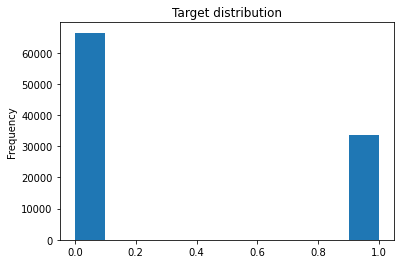

In [ ]:
train_df.label.plot(kind='hist', title='Target distribution')

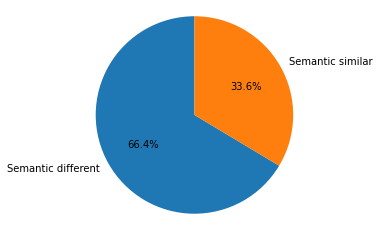

In [ ]:
labels = 'Semantic different', 'Semantic similar'
semantic_different_size = train_df.loc[train_df['label'] == 0].count()["label"]
semantic_similar_size = train_df.loc[train_df['label'] == 1].count()["label"]
sizes = [semantic_different_size, semantic_similar_size]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices(
        (train_df['sentence1'].values, train_df['sentence2'].values,  train_df['label'].values))
    valid_data = tf.data.Dataset.from_tensor_slices(
        (valid_df['sentence1'].values, valid_df['sentence2'].values, valid_df['label'].values))

    for sentence1, sentence2, label in train_data.take(1):
        print("First item in train data:")
        print(sentence1)
        print(sentence2)
        print(label)
        
    for sentence1, sentence2, label in valid_data.take(1):
        print("First item in valid data:")
        print(sentence1)
        print(sentence2)
        print(label)

    # train
    train_data = data_generator(train_data, shuffle=True)

    # valid
    valid_data = data_generator(valid_data) 

First item in train data:
tf.Tensor(b'A couple is holding their baby at a ceremony while the priest reads his book.', shape=(), dtype=string)
tf.Tensor(b'\xd0\xb2\xd0\xb5\xd0\xb4\xd0\xb5 \xd1\x81\xd0\xb2\xd0\xbe\xd1\x8e \xd0\xb4\xd0\xb8\xd1\x82\xd0\xb8\xd0\xbd\xd1\x83 \xd0\xb2 \xd0\xb7\xd0\xbe\xd0\xbe\xd0\xbf\xd0\xb0\xd1\x80\xd0\xba', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
First item in valid data:
tf.Tensor(b'A group of people are running in the cold.', shape=(), dtype=string)
tf.Tensor(b'\xd0\x9a\xd1\x83\xd0\xbf\xd0\xb0 \xd0\xbb\xd1\x8e\xd0\xb4\xd0\xb5\xd0\xb9, \xd1\x89\xd0\xbe \xd1\x80\xd1\x83\xd1\x85\xd0\xb0\xd1\x8e\xd1\x82\xd1\x8c\xd1\x81\xd1\x8f \xd0\xb6\xd0\xb2\xd0\xb0\xd0\xb2\xd0\xbe \xd0\xb2 \xd1\x85\xd0\xbe\xd0\xbb\xd0\xbe\xd0\xb4\xd0\xbd\xd0\xb8\xd0\xb9 \xd0\xb4\xd0\xb5\xd0\xbd\xd1\x8c', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

Now we can build our model

In [ ]:
model = create_model(bert_layer)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'pooled_output': (N 177853441   input_mask[0][0]                 
                                                                 input_type_ids[0][0]  

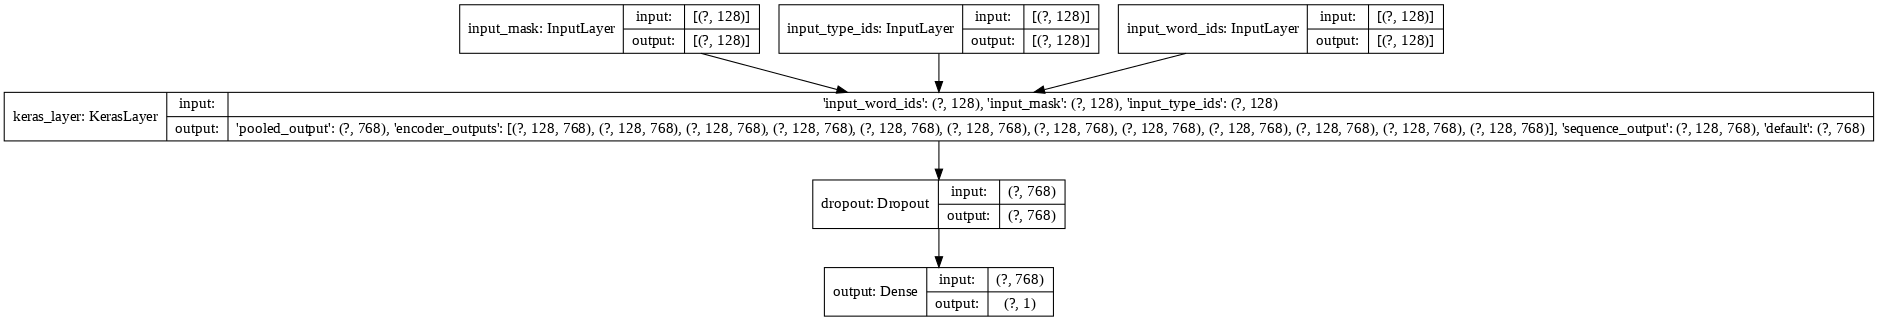

In [ ]:
plot_model(model)

In [ ]:
# Train model
epochs = 2 # or 4 in the future if colab will don't freak out with it
history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=epochs,
                    use_multiprocessing=True,
                    workers=-1,
                    verbose=1)

Epoch 1/2
3125/3125 [==============================] - ETA: 0s - loss: 0.3689 - binary_accuracy: 0.8367WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0361s vs `on_test_batch_end` time: 0.2452s). Check your callbacks.


3125/3125 [==============================] - 3126s 1s/step - loss: 0.3689 - binary_accuracy: 0.8367 - val_loss: 0.3147 - val_binary_accuracy: 0.8668
Epoch 2/2
3125/3125 [==============================] - 3128s 1s/step - loss: 0.2160 - binary_accuracy: 0.9138 - val_loss: 0.3823 - val_binary_accuracy: 0.8710


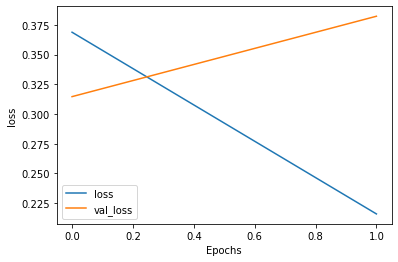

In [ ]:
plot_graphs(history, 'loss')

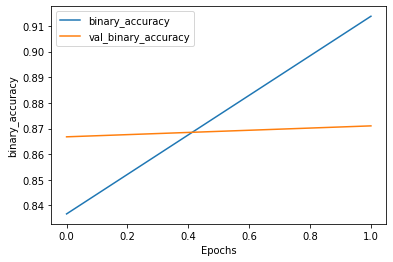

In [ ]:
plot_graphs(history, 'binary_accuracy')

In [ ]:
sentences1 = ["A smiling costumed woman is holding an umbrella", "Puppets love swimming", "I love cats", "I love cats", "I love cats", "Я обожнюю котів", "Я обожнюю котів", "Manager is a person responsibe for a company", "Менеджер це людина, що відповідальна за компанію"]
sentences2 = ["A happy woman in a fairy costume holds an umbrella", "I play football", "I love cats", "I love dogs", "Я обожнюю котів", "Я обожнюю котів", "Я обожнюю собак", "Менеджер це людина, що відповідальна за компанію", "Manager is a person responsibe for a company"]
test_data = tf.data.Dataset.from_tensor_slices((sentences1, sentences2, [0]*len(sentences1)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.7 #between 0 and 1
[(pred, 'Semantic simillar' if pred >= threshold else 'Semantic different') for pred in preds]

[(array([0.03549498], dtype=float32), 'Semantic different'),
 (array([7.199144e-06], dtype=float32), 'Semantic different'),
 (array([0.9822009], dtype=float32), 'Semantic simillar'),
 (array([0.01607955], dtype=float32), 'Semantic different'),
 (array([0.0308189], dtype=float32), 'Semantic different'),
 (array([0.9730005], dtype=float32), 'Semantic simillar'),
 (array([0.5753847], dtype=float32), 'Semantic different'),
 (array([0.9485759], dtype=float32), 'Semantic simillar'),
 (array([0.98753023], dtype=float32), 'Semantic simillar')]

In [ ]:
# save model and architecture to single file
# Save the entire model as a SavedModel.
model.save("/content/gdrive/My Drive/semantic_binary_multilang_classification1_model.h5")
print("Model was saved to google disk")

Model was saved to google disk


## Plagiarism detection

Data - https://ir.shef.ac.uk/cloughie/resources/plagiarism_corpus.html

`The corpus contains 100 documents (95 answers provided by the 19 participants and the five Wikipedia source articles). For each learning task, there are 19 examples of each of the heavy revision, light revision and near copy levels and 38 non-plagiarised examples written independently from the Wikipedia source (there is an uneven spread in the number of answers across tasks and categories results from using a Latin-square arrangement to order the tasks carried out by the 19 participants). The answer texts contain 19,559 words in total (2,2230 unique tokens) and the the Wikipedia pages total 14,242 words after conversion to plaintext using lynx -dump and removal of URL references. The average length of file in the corpus is 208 words (std dev. 64.91) and 113 unique tokens (std dev. 30.11). Overall, 59 (62%) of the files are written by native English speakers; the remaining 36 (38%) by non-native speakers.`

Corpus link - https://ir.shef.ac.uk/cloughie/resources/corpus-final09.zip

### Load the data

In [ ]:
!curl -LO https://ir.shef.ac.uk/cloughie/resources/corpus-final09.zip
!unzip corpus-final09.zip

!curl -LO https://raw.githubusercontent.com/UndeadBigUnicorn/Plagiarism_Detection/master/data/file_information.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 76688  100 76688    0     0  50585      0  0:00:01  0:00:01 --:--:-- 50585
Archive:  corpus-final09.zip
  inflating: corpus-20090418/g0pA_taska.txt  
  inflating: corpus-20090418/g0pA_taskb.txt  
  inflating: corpus-20090418/g0pA_taskc.txt  
  inflating: corpus-20090418/g0pA_taskd.txt  
  inflating: corpus-20090418/g0pA_taske.txt  
  inflating: corpus-20090418/g0pB_taska.txt  
  inflating: corpus-20090418/g0pB_taskb.txt  
  inflating: corpus-20090418/g0pB_taskc.txt  
  inflating: corpus-20090418/g0pB_taskd.txt  
  inflating: corpus-20090418/g0pB_taske.txt  
  inflating: corpus-20090418/g0pC_taska.txt  
  inflating: corpus-20090418/g0pC_taskb.txt  
  inflating: corpus-20090418/g0pC_taskc.txt  
  inflating: corpus-20090418/g0pC_taskd.txt  
  inflating: corpus-20090418/g0pC_taske.txt  
  inflating: corpus-20090418/g0pD_taska.txt 

In [ ]:
!rm -rf data
!mv corpus-20090418 data
!mv file_information.csv data

In [ ]:
csv_file = 'data/file_information.csv'
plagiarism_df = pd.read_csv(csv_file)

# print out the first few rows of data info
plagiarism_df.head(10)

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non
5,g0pB_taska.txt,a,non
6,g0pB_taskb.txt,b,non
7,g0pB_taskc.txt,c,cut
8,g0pB_taskd.txt,d,light
9,g0pB_taske.txt,e,heavy


### Types of Plagiarism
Each text file is associated with one **Task** (task A-E) and one **Category** of plagiarism, which you can see in the above DataFrame.

#### Five task types, A-E
Each text file contains an answer to one short question; these questions are labeled as tasks A-E.

- Each task, A-E, is about a topic that might be included in the Computer Science curriculum that was created by the authors of this dataset.
  - For example, Task A asks the question: "What is inheritance in object oriented programming?"

#### Four categories of plagiarism
Each text file has an associated plagiarism label/category:

1. cut: An answer is plagiarized; it is copy-pasted directly from the relevant Wikipedia source text.
2. light: An answer is plagiarized; it is based on the Wikipedia source text and includes some copying and paraphrasing.
3. heavy: An answer is plagiarized; it is based on the Wikipedia source text but expressed using different words and structure. Since this doesn't copy directly from a source text, this will likely be the most challenging kind of plagiarism to detect.
4. non: An answer is not plagiarized; the Wikipedia source text is not used to create this answer.
5. orig: This is a specific category for the original, Wikipedia source text. We will use these files only for comparison purposes.

> So, out of the submitted files, the only category that does not contain any plagiarism is non.

In [ ]:
# print out some stats about the data
print('Number of files: ', plagiarism_df.shape[0])  # .shape[0] gives the rows 
# .unique() gives unique items in a specified column
print('Number of unique tasks/question types (A-E): ', (len(plagiarism_df['Task'].unique())))
print('Unique plagiarism categories: ', (plagiarism_df['Category'].unique()))

Number of files:  100
Number of unique tasks/question types (A-E):  5
Unique plagiarism categories:  ['non' 'cut' 'light' 'heavy' 'orig']


> So, in total there are 100 files, 95 of which are answers (submitted by people) and 5 of which are the original, Wikipedia source texts.



### Data distribution 

In [ ]:
# Show counts by different tasks and amounts of plagiarism

# group and count by task
counts_per_task=plagiarism_df.groupby(['Task']).size().reset_index(name="Counts")
print("\nTask:")
display(counts_per_task)

# group by plagiarism level
counts_per_category=plagiarism_df.groupby(['Category']).size().reset_index(name="Counts")
print("\nPlagiarism Levels:")
display(counts_per_category)

# group by task AND plagiarism level
counts_task_and_plagiarism=plagiarism_df.groupby(['Task', 'Category']).size().reset_index(name="Counts")
print("\nTask & Plagiarism Level Combos :")
display(counts_task_and_plagiarism)


Task:


,Task,Counts
0,a,20
1,b,20
2,c,20
3,d,20
4,e,20



Plagiarism Levels:


,Category,Counts
0,cut,19
1,heavy,19
2,light,19
3,non,38
4,orig,5



Task & Plagiarism Level Combos :


,Task,Category,Counts
0,a,cut,4
1,a,heavy,3
2,a,light,3
3,a,non,9
4,a,orig,1
5,b,cut,3
6,b,heavy,4
7,b,light,3
8,b,non,9
9,b,orig,1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


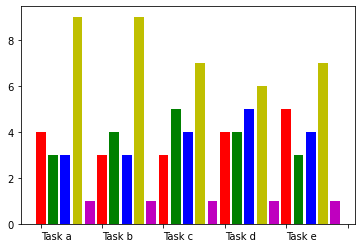

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

# counts
group = ['Task', 'Category']
counts = plagiarism_df.groupby(group).size().reset_index(name="Counts")

fig1, ax1 = plt.subplots()
ax1.set_xticklabels(["", "Task a", "Task b", "Task c", "Task d", "Task e"], ha="left")
ax1.bar(range(len(counts)), counts['Counts'], color = ['r','g','b','y','m'])
plt.show()

In [ ]:
# Read in a csv file and return a transformed dataframe
def numerical_dataframe(csv_file='data/file_information.csv'):
    '''Reads in a csv file which is assumed to have `File`, `Category` and `Task` columns.
       This function does two things: 
       1) converts `Category` column values to numerical values 
       2) Adds a new, numerical `Class` label column.
       The `Class` column will label plagiarized answers as 1 and non-plagiarized as 0.
       Source texts have a special label, -1.
       :param csv_file: The directory for the file_information.csv file
       :return: A dataframe with numerical categories and a new `Class` label column'''
    
    # read in csv file
    num_df = pd.read_csv(csv_file)
    
    # convert Category column to numerical values
    cat_num = {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3, 'orig': -1}
    num_df['Category'] = num_df['Category'].map(cat_num)
    
    # add Target column
    # num_df['Target'] = [ x for x in num_df['Category'] ]
    num_df['Target'] = [ x if x < 1 else 1 for x in num_df['Category'] ]
    
    return num_df

In [ ]:
plagiarism_df = numerical_dataframe(csv_file ='data/file_information.csv')

# check that all categories of plagiarism have a class label = 1
plagiarism_df.head(10)

,File,Task,Category,Target
0,g0pA_taska.txt,a,0,0
1,g0pA_taskb.txt,b,3,1
2,g0pA_taskc.txt,c,2,1
3,g0pA_taskd.txt,d,1,1
4,g0pA_taske.txt,e,0,0
5,g0pB_taska.txt,a,0,0
6,g0pB_taskb.txt,b,0,0
7,g0pB_taskc.txt,c,3,1
8,g0pB_taskd.txt,d,2,1
9,g0pB_taske.txt,e,1,1


<AxesSubplot:title={'center':'Target distribution'}, ylabel='Frequency'>

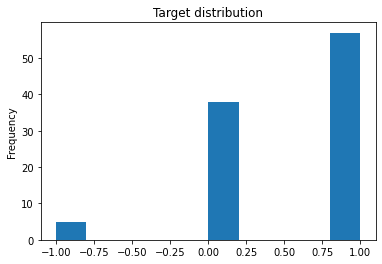

In [ ]:
plagiarism_df["Target"].plot(kind='hist', title='Target distribution')

In [ ]:
# helper function for pre-processing text given a file
def process_file(file):

    return process_text(file.read())

def create_text_column(df, file_directory='data/'):
    '''Reads in the files, listed in a df and returns that df with an additional column, `Text`. 
       :param df: A dataframe of file information including a column for `File`
       :param file_directory: the main directory where files are stored
       :return: A dataframe with processed text '''
   
    # create copy to modify
    text_df = df.copy()
    
    # store processed text
    text = []
    
    # for each file (row) in the df, read in the file 
    for row_i in df.index:
        filename = df.iloc[row_i]['File']
        #print(filename)
        file_path = file_directory + filename
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:

            # standardize text using helper function
            file_text = process_file(file)
            # append processed text to list
            text.append(file_text)
    
    # add column to the copied dataframe
    text_df['Text'] = text
    
    return text_df

text_df = create_text_column(plagiarism_df)
text_df.head()

,File,Task,Category,Target,Text
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object-orien...
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,"the vector space model (also called, term vect..."
3,g0pA_taskd.txt,d,1,1,bayes’ theorem was names after rev thomas baye...
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...


In [ ]:
row_idx = 0 # feel free to change this index

sample_text = text_df.iloc[0]['Text']

print('Sample processed text:\n\n', sample_text)

Sample processed text:

 inheritance is a basic concept of object-oriented programming where the basic idea is to create new classes that add extra detail to existing classes. this is done by allowing the new classes to reuse the methods and variables of the existing classes and new methods and classes are added to specialise the new class. inheritance models the “is-kind-of” relationship between entities (or objects), for example, postgraduates and undergraduates are both kinds of student. this kind of relationship can be visualised as a tree structure, where ‘student’ would be the more general root node and both ‘postgraduate’ and ‘undergraduate’ would be more specialised extensions of the ‘student’ node (or the child nodes). in this relationship ‘student’ would be known as the superclass or parent class whereas, ‘postgraduate’ would be known as the subclass or child class because the ‘postgraduate’ class extends the ‘student’ class. inheritance can occur on several layers, where if 

Now we need to convert data to format that was used to train base model: <br/>
`text_a`, `text_b`, `target`

In [ ]:
def create_text_pairs(df):
  '''Convert df to such format `text_a`, `text_b`, `target`'''
  new_df = pd.DataFrame()

  text_a = []
  text_b = []
  targets = []

  for task, task_df in df.groupby(['Task']):
    orig_text = task_df[task_df['Category']==-1]['Text'].item()

    for index, row in task_df.iterrows():
      text_a.append(orig_text)
      text_b.append(row['Text'])
      targets.append(row['Target'] if row['Target'] != -1 else 1)

  new_df['Text A'] = text_a
  new_df['Text B'] = text_b
  new_df['Target'] = targets

  return new_df

In [ ]:
plagiarism_df = create_text_pairs(text_df)
plagiarism_df.tail(10)

,Text A,Text B,Target
90,"in mathematics and computer science, dynamic p...",dynamic programming is a problem-solving metho...,1
91,"in mathematics and computer science, dynamic p...",dynamic programming (dp) is in basic terms an ...,0
92,"in mathematics and computer science, dynamic p...","in the field of computer science, term 'dynami...",0
93,"in mathematics and computer science, dynamic p...",dynamic programming is a method of solving pro...,1
94,"in mathematics and computer science, dynamic p...","in computer science and mathematics, dynamic p...",1
95,"in mathematics and computer science, dynamic p...","in mathematics and computer science, dynamic p...",1
96,"in mathematics and computer science, dynamic p...","in mathematics and computer science, dynamic p...",1
97,"in mathematics and computer science, dynamic p...",dynamic programming is a method of providing s...,1
98,"in mathematics and computer science, dynamic p...",dynamic programming is a method for efficient...,0
99,"in mathematics and computer science, dynamic p...","in mathematics and computer science, dynamic p...",1


Now we can load the translated corpus from google drive. The preparation there was made the same

In [ ]:
!cp '/content/gdrive/My Drive/plagiarism_translated_data.zip' plagiarism_translated_data.zip
!unzip plagiarism_translated_data.zip

Archive:  plagiarism_translated_data.zip
   creating: plagiarism_data/
  inflating: plagiarism_data/corpus.csv  


In [ ]:
plagiarism_df = pd.read_csv("plagiarism_data/corpus.csv")

# Shape of the data
print(f"Total samples : {plagiarism_df.shape[0]}")

plagiarism_df.shape

Total samples : 400


(400, 4)

In [ ]:
plagiarism_df

,Unnamed: 0,Text A,Text B,Target
0,0,in object oriented programming inheritance is ...,inheritance is a basic concept of object orien...,0
1,1,in object oriented programming inheritance is ...,успадкування - це основна концепція об'єктно-о...,0
2,2,в об'єктно-орієнтованому програмуванні успадку...,inheritance is a basic concept of object orien...,0
3,3,в об'єктно-орієнтованому програмуванні успадку...,успадкування - це основна концепція об'єктно-о...,0
4,4,in object oriented programming inheritance is ...,inheritance is a basic concept in object orien...,0
...,...,...,...,...
395,395,в математиці та інформатиці динамічне програму...,динамічне програмування - це метод для ефекти...,0
396,396,in mathematics and computer science dynamic pr...,in mathematics and computer science dynamic pr...,1
397,397,in mathematics and computer science dynamic pr...,в математиці та інформатиці динамічне програму...,1
398,398,в математиці та інформатиці динамічне програму...,in mathematics and computer science dynamic pr...,1


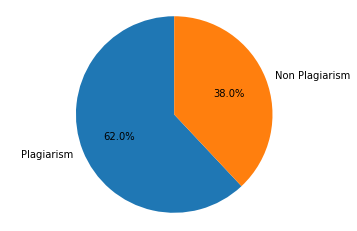

In [ ]:
labels = 'Plagiarism', 'Non Plagiarism'
plagiarism_size = plagiarism_df.loc[plagiarism_df['Target'] == 1].count()["Target"]
non_plagiarism_size = plagiarism_df.loc[plagiarism_df['Target'] == 0].count()["Target"]
sizes = [plagiarism_size, non_plagiarism_size]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Split data into `train`, `valid` and `test`

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, remaining = train_test_split(plagiarism_df, random_state=42, train_size=0.75, stratify=plagiarism_df.Target.values)
valid_df, test_df = train_test_split(remaining, random_state=42, train_size=0.8, stratify=remaining.Target.values)
train_df.shape, valid_df.shape, test_df.shape

((300, 4), (80, 4), (20, 4))

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['Text A'].values, train_df['Text B'].values, train_df['Target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['Text A'].values, valid_df['Text B'].values, valid_df['Target'].values))
  test_data = tf.data.Dataset.from_tensor_slices((test_df['Text A'].values, test_df['Text B'].values, test_df['Target'].values))

  for text_a, text_b, label in train_data.take(1):
    print(text_a.numpy().decode("utf-8"))
    print(text_b)
    print(label)

  # train
  train_data = data_generator(train_data, shuffle=True, batch_size=4)
  # valid
  valid_data = data_generator(valid_data, batch_size=4) 
  # test
  test_data = data_generator(test_data, batch_size=4) 

векторна космічна модель або термін Векторна модель - це алгебраїчна модель для представлення текстових документів та будь-яких об'єктів загалом як векторів ідентифікаторів, таких як, наприклад, терміни індексу; вона використовується у фільтрації інформації, індексація пошуку інформації та рейтинги відповідності, її перше використання було в розумній інформації система пошуку документ представлений у вигляді вектора, кожному виміру відповідає окремий термін, якщо термін зустрічається в документі, його значення у векторі не дорівнює нулю, кілька різних способів обчислення цих значень, також відомих як ваги термінів, були розроблені одним з найкращих відомі схеми tf idf зважування див. приклад нижче визначення терміна залежить від застосування, як правило, терміни - це окремі слова, ключові слова або довші фрази, якщо слова обрані як терміни, розмірність вектора - це кількість слів у словниковому запасі. Кількість різних слів, що зустрічаються в корпусі, векторна космічна модель має такі

In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(4, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(4, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(4, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(4,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(4, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(4, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(4, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(4,), dtype=tf.int32, name=None))

In [ ]:
# test data spec
test_data.element_spec

({'input_mask': TensorSpec(shape=(4, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(4, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(4, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(4,), dtype=tf.int32, name=None))

In [ ]:
batch_size = 4

In [ ]:
# load model
base_model = tf.keras.models.load_model("/content/gdrive/My Drive/semantic_binary_multilang_classification1_model.h5", custom_objects={'KerasLayer': hub.KerasLayer})
base_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'sequence_output':  177853441   input_mask[0][0]                 
                                                                 input_type_ids[0][0]  

In [ ]:
model = create_model(base_model, droput = False)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1)            177854210   input_mask[0][0]                 
                                                                 input_type_ids[0][0]  

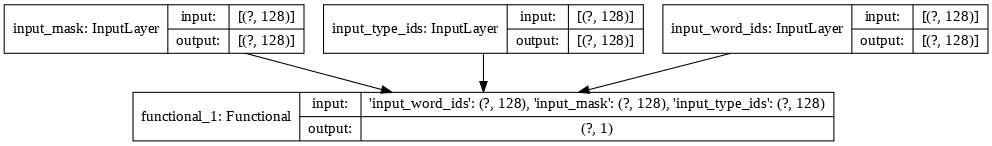

In [ ]:
plot_model(model)

In [ ]:
# Train model
epochs = 4 # it has overfit after the 4th epoch, see val_loss
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

Epoch 1/4
75/75 [==============================] - 14s 185ms/step - loss: 0.0386 - binary_accuracy: 0.9767 - val_loss: 0.0457 - val_binary_accuracy: 0.9750
Epoch 2/4
75/75 [==============================] - 14s 184ms/step - loss: 0.0179 - binary_accuracy: 0.9933 - val_loss: 0.0053 - val_binary_accuracy: 1.0000
Epoch 3/4
75/75 [==============================] - 14s 183ms/step - loss: 3.8499e-04 - binary_accuracy: 1.0000 - val_loss: 0.0109 - val_binary_accuracy: 0.9875
Epoch 4/4
75/75 [==============================] - 14s 182ms/step - loss: 2.0539e-04 - binary_accuracy: 1.0000 - val_loss: 0.0038 - val_binary_accuracy: 1.0000


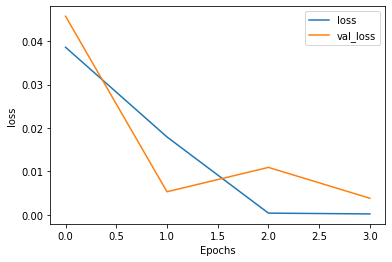

In [ ]:
plot_graphs(history, 'loss')

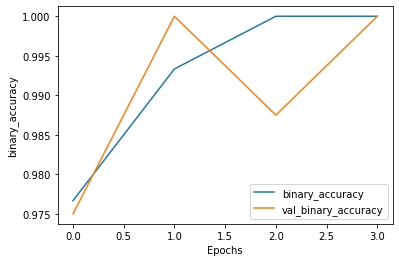

In [ ]:
plot_graphs(history, 'binary_accuracy')

In [ ]:
model.save("/content/gdrive/My Drive/plagiarism_binary_multilang_classification1_model.h5")
print("Model was saved to google disk")

Model was saved to google disk


In [ ]:
from sklearn.metrics import classification_report

y_test = test_df['Target'].values[:test_df.shape[0]]
threshold = 0.7 #between 0 and 1

y_pred = model.predict(test_data, batch_size=4, verbose=1)
y_pred_bool = [1 if pred >= threshold else 0 for pred in y_pred]
print(classification_report(y_test, y_pred_bool))

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# Print f1, precision, and recall scores
print("Precision: ", precision_score(y_test, y_pred_bool , average="macro"))
print("Recall score: ", recall_score(y_test, y_pred_bool , average="macro"))
print("F1 score: ", f1_score(y_test, y_pred_bool , average="macro"))

5/5 [==============================] - 0s 48ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        12

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Precision:  1.0
Recall score:  1.0
F1 score:  1.0


In [ ]:
model = tf.keras.models.load_model("/content/gdrive/My Drive/plagiarism_binary_multilang_classification1_model.h5", custom_objects={'KerasLayer': hub.KerasLayer})
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1)            177854210   input_mask[0][0]                 
                                                                 input_type_ids[0][0]  

In [ ]:
def check_plagiarism(text_a, text_b, model=model):

    assert len(text_a) == len(text_b)

    text_a = list(map(lambda x: process_text(x), text_a))
    text_b = list(map(lambda x: process_text(x), text_b))

    test_data = tf.data.Dataset.from_tensor_slices((text_a, text_b, [0]*len(text_a)))
    test_data = (test_data.map(to_feature_map).batch(1))
    preds = model.predict(test_data)

    # return [(labels[np.argmax(proba)], f"{proba[np.argmax(proba)]: .2f}%") for proba in preds]

    preds = model.predict(test_data)
    threshold = 0.7 #between 0 and 1
    return [("{:.2f}%".format(pred[0]*100), labels[1] if pred >= threshold else labels[0], text_a[i], text_b[i]) for i, pred in enumerate(preds)]

In [ ]:
# orig
big_text_a1 = """In object-oriented programming, inheritance is a way to form new classes (instances of which are called objects) using classes that have already been defined. The inheritance concept was invented in 1967 for Simula.

The new classes, known as derived classes, take over (or inherit) attributes and behavior of the pre-existing classes, which are referred to as base classes (or ancestor classes). It is intended to help reuse existing code with little or no modification.

Inheritance provides the support for representation by categorization in computer languages. Categorization is a powerful mechanism number of information processing, crucial to human learning by means of generalization (what is known about specific entities is applied to a wider group given a belongs relation can be established) and cognitive economy (less information needs to be stored about each specific entity, only its particularities).

Inheritance is also sometimes called generalization, because the is-a relationships represent a hierarchy between classes of objects. For instance, a "fruit" is a generalization of "apple", "orange", "mango" and many others. One can consider fruit to be an abstraction of apple, orange, etc. Conversely, since apples are fruit (i.e., an apple is-a fruit), apples may naturally inherit all the properties common to all fruit, such as being a fleshy container for the seed of a plant.

An advantage of inheritance is that modules with sufficiently similar interfaces can share a lot of code, reducing the complexity of the program. Inheritance therefore has another view, a dual, called polymorphism, which describes many pieces of code being controlled by shared control code.
Inheritance is typically accomplished either by overriding (replacing) one or more methods exposed by ancestor, or by adding new methods to those exposed by an ancestor.

Complex inheritance, or inheritance used within a design that is not sufficiently mature, may lead to the Yo-yo problem."""
# heavy
big_text_b1 = """
inheritance in object oriented programming is where a new class is formed using classes which have allready been defined. 
These classes have have some of the behavior and attributes which where existent in the classes that it inherited from. 
The peropos of inheritance in object oriented programming is to minimize the reuse of existing code without modification.

Inheritance allowes classes to be categorized, similer to the way humans catagorize. It also provides a way to generalize du to the "is a" relationship between classes. For example a "cow" is a generalization of "animal" similarly so are "pigs" & cheaters". Defeining classes in this way, allows us to define attributes and behaviours which are commen to all animals in one class, so cheaters would natuarly inheart properities commen to all animals.

The advantage of inheritance is that classes which would otherwise have alot of similar code , can instead shair the same code, thus reducing the complexity of the program. Inheritance, therefore, can also be refered to as polymorphism which is where many pieces of code are controled by shared control code.

Inheritance can be accomplished by overriding methods in its ancestor, or by adding new methods. 
"""
# cut
big_text_b2 = """
Inheritance in object oriented programming is a way to form new classes using classes that have already been defined. The new classes, known as derived classes, inherit attributes and behaviour of the existing classes, which are referred to as base classes. With little or no modification, it is intended to help reuse existing code. It is typically accomplished either by overriding one or more methods exposed by ancestor, or by adding new methods to those exposed by an ancestor

Inheritance is also sometimes called generalization, because there is-a relationships represent a hierarchy between classes of objects. A ‘fruit’, for instance, is a generalization of "orange", "mango", "apples" and many others. One can consider fruit to be an abstraction of apple, orange, etc. Since apples are fruit (i.e., an apple is-a fruit), conversely apples may naturally inherit all the properties common to all fruit, such as being a fleshy container for the seed of a plant.

An advantage of inheritance is that modules with sufficiently similar interfaces can share a lot of code reducing the complexity of the program. 
"""

#non
big_text_b3 = """
In object oriented programming, objects are grouped together into classes according to their type, structure and the functions that can be performed on them. Inheritance is a process in object oriented programming in which objects acquire (or inherit) the properties of objects of another class. It is therefore used to create relationships between one object and another. Each class groups together objects of a similar type, with similar properties. New classes can be formed by this process whose objects will have properties of both the classes from which this new class is formed. A superclass has all of the properties of the subclasses below it. At the same time subclasses are each distinctive from each other but related via the superclass. Subclasses are said to ‘extend’ superclasses. Due to these relationships, object oriented programmes tend to be easier to modify since they do not need to be changed when a new object, with different properties is added. Instead, a new object is made to inherit properties of objects which already exist. Inheritance can be divided into two main processes: single inheritance and multiple inheritance. Single inheritance means that the class can only inherit from one other class, whereas multiple inheritance allows for inheritance from several classes.

"""

# orig text translated English -> Russian -> Ukrainian -> German -> English
big_text_b4 = """
In object-oriented programming, inheritance is a way of creating new classes (of which instances are referred to as objects) using classes that have already been defined. The concept of inheritance was invented for Simula in 1967.

New classes, called descendant classes, inherit (or inherit) the attributes and behavior of existing classes called base classes (or ancestral classes). It is designed to reuse existing code with or without minor changes.

Inheritance provides representation support through categorization in computer languages. Categorization is a powerful information handling mechanism that works for human learning through generalization (what is known about certain objects is applied to a broader group if a membership can be made) and cognitive economy (less information needs to be stored) about each particular Entity is critical. only its properties).

Inheritance is sometimes referred to as generalization because the relationship is a hierarchy between object classes. For example, "fruit" is a generalization of the words "apple", "orange", "mango" and many others. Fruit can be thought of as an abstraction from apple, orange, etc. Of course, since apples are fruit (that is, an apple is a fruit), apples can inherit all of the properties common to all fruits, such as: B. a meaty container. for plant seeds.

The advantage of inheritance is that modules with fairly similar interfaces can share a large amount of code, which reduces the complexity of the program. So imitation has a different concept, a double one, called polymorphism, which describes many code fragments that are controlled by a common control code.
Inheritance is usually done either by redefining (replacing) one or more ancestral methods or by adding new methods to the ancestral methods.

Complex inheritance, or inheritance used in an immature design, can create a yo-yo problem.
"""
# original from https://medium.com/javascript-scene/master-the-javascript-interview-what-is-functional-programming-7f218c68b3a0#:~:text=Functional%20programming%20(often%20abbreviated%20FP,state%20flows%20through%20pure%20functions.
big_text_a2 = """
Functional programming (often abbreviated FP) is the process of building software by composing pure functions, avoiding shared state, mutable data, and side-effects. 
Functional programming is declarative rather than imperative, and application state flows through pure functions. Contrast with object oriented programming, where application state is usually shared and colocated with methods in objects.
Functional programming is a programming paradigm, meaning that it is a way of thinking about software construction based on some fundamental, defining principles (listed above).
"""
# paraphrase
big_text_b5 = """
Functional programming is a programming paradigm, that allows to develop software by composing functions, keeping away from shared state, mutable data and side-effects.
In functional programming application state goes through pure functions. This paradigm is opposite to applications that were built using the object oriented programming. State in those applications is often shared and compiled with methods in objects.
Functional programming is rather a way of thinking about developing software based on fundamental rules.
"""
# original from https://marketbusinessnews.com/financial-glossary/manager-definition-meaning/
big_text_a3 = """
A manager is a person who is responsible for a part of a company, i.e., they ‘manage‘ the company. 
Managers may be in charge of a department and the people who work in it. In some cases, the manager is in charge of the whole business. 
The Manager’s duties also include managing employees or a section of the company on a day-to-day basis.
"""
# paraphrase
big_text_b6 = """
A manager is a person responsible for controlling or administering an organization or group of staff.
Managers could be responsible for a part of the company and the employers who work there. Sometimes the manager is a head of the whole company.
Reponsibilities of the manager include control workers or lead a part of the company too.
"""
# original from https://marketbusinessnews.com/financial-glossary/manager-definition-meaning/
# with extra sentence
big_text_a4 = """
A manager is a person who is responsible for a part of a company, i.e., they ‘manage‘ the company. 
Managers may be in charge of a department and the people who work in it. In some cases, the manager is in charge of the whole business. 
The Manager’s duties also include managing employees or a section of the company on a day-to-day basis.
For example, a restaurant manager is in charge of the whole restaurant.
"""
# paraphrase
big_text_b7 = """
A manager is a person responsible for controlling or administering an organization or group of staff.
Managers could be responsible for a part of the company and the employers who work there. Sometimes the manager is a head of the whole company.
Reponsibilities of the manager include control workers or lead a part of the company too.
For instance, a store manager is responsible for the whole store.
"""
# original wikipedia
big_text_a5 = """
In mathematics and statistics, the arithmetic mean, or simply the mean or the average (when the context is clear), is the sum of a collection of numbers divided by the count of numbers in the collection.
"""

# original wikipedia uk
big_text_b8 = """
Арифметичне середнє (в математиці і статистиці) — сума всіх фіксованих значень набору, поділена на кількість елементів набору
"""
# original wikipedia
big_text_a6 = """
Тара́с Григо́рович Шевче́нко (відомий також як Кобза́р; 25 лютого (9 березня) 1814, с. Моринці, Київська губернія, Російська імперія (нині Звенигородський район, Черкаська область, Україна) — 26 лютого (10 березня) 1861, Санкт-Петербург, Російська імперія) — український письменник, класик української літератури, мислитель, художник. Національний герой і символ України.
"""
big_text_b9 = """
Franklin Delano Roosevelt (/ˈroʊzəvəlt/,[1] /-vɛlt/[2] ROH-zə-velt; January 30, 1882 – April 12, 1945), often referred to by his initials FDR, was an American politician who was the 32nd president of the United States from 1933 until his death in 1945. A member of the Democratic Party, he won a record four presidential elections and became a central figure in world events during the first half of the 20th century. 
"""
text_a = ["Hello world", "Менеджер це людина, що відповідальна за компанію", "A smiling costumed woman is holding an umbrella",  
          big_text_a1, big_text_a1, big_text_a1, big_text_a1, big_text_a2, big_text_a3, big_text_a4, big_text_a5, big_text_a6]
text_b = ["Hello world", "Manager is a person responsibe for a company", "A happy woman in a fairy costume holds an umbrella", 
          big_text_b1, big_text_b2, big_text_b3, big_text_b4, big_text_b5, big_text_b6, big_text_b7, big_text_b8, big_text_b9]
check_plagiarism(text_a, text_b)

[('99.96%', 'plagiarism', 'hello world', 'hello world'),
 ('99.99%',
  'plagiarism',
  'менеджер це людина, що відповідальна за компанию',
  'manager is a person responsibe for a company'),
 ('96.06%',
  'plagiarism',
  'a smiling costumed woman is holding an umbrella',
  'a happy woman in a fairy costume holds an umbrella'),
 ('100.00%',
  'plagiarism',
  'in object-oriented programming, inheritance is a way to form new classes (instances of which are called objects) using classes that have already been defined. the inheritance concept was invented in for simula. the new classes, known as derived classes, take over (or inherit) attributes and behavior of the pre-existing classes, which are referred to as base classes (or ancestor classes). it is intended to help reuse existing code with little or no modification. inheritance provides the support for representation by categorization in computer languages. categorization is a powerful mechanism number of information processing, crucial 